# Gender Classification Project

In this notebook we will use [Gender Classification Dataset](https://www.kaggle.com/cashutosh/gender-classification-dataset) from Kaggle. This is a dataset with cropped images of male and female. It is split into training and validation directory. Training contains ~23,000 images of each class and validation directory contains ~5,500 iamges of each class. Our *goal* is to correctly predict gender: `male` or `female`. 

To achieve better result, we will use [ResNet](https://arxiv.org/abs/1512.03385)(Residual Network) model variants. ResNet was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), and won it in 2015.


## Data Processing

We start by importing all the necessary modules
 - `lr-scheduler` - for using the one cycle learning rate schedule, from [this paper](https://arxiv.org/abs/1803.09820)
 - `namedtuple` - for handling ResNet configurations
 - `os` and `shutil` for handling custom datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy 
from collections import namedtuple
import os
import random
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

We set the random seeds for reproducability

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load and Augment Data

In [3]:
data_dir = 'D:/datasets/gender_kaggle'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Validation')
classes = os.listdir(train_dir)

In [4]:
classes

['female', 'male']

### Normalizing the data

In [5]:
# train_data = datasets.ImageFolder(root=train_dir, transform = transforms.ToTensor())

# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train_data:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))
    
# means /= len(train_data)
# stds /= len(train_data)

# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

### Augmentation

As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use the following data augmentation methods: randomly  rotating, flipping horizontally and cropping.

In [6]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

# load the data with transforms
train_data = datasets.ImageFolder(root=train_dir, transform = train_transforms)

test_data = datasets.ImageFolder(root=test_dir, transform = test_transforms)

# create the validation split
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

overwrite the validation transforms, making sure to do a deepcopy to stop this also chaing the training data transforms

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Now let's see the number of examples for each of the data splits

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 42308
Number of validation examples: 4701
Number of testing examples: 11649


Now, we prepare dataloader (combine dataset and sampler) with largest batch size that fits on our GPU

In [9]:
BATCH_SIZE = 32

train_loader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [11]:
def plot_images(images, labels, classes, normalize = True):
    
    n_images = len(images)
    
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize=(10,10))
    
    for i in range(rows*cols):
        
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [12]:
test_data.classes

['female', 'male']

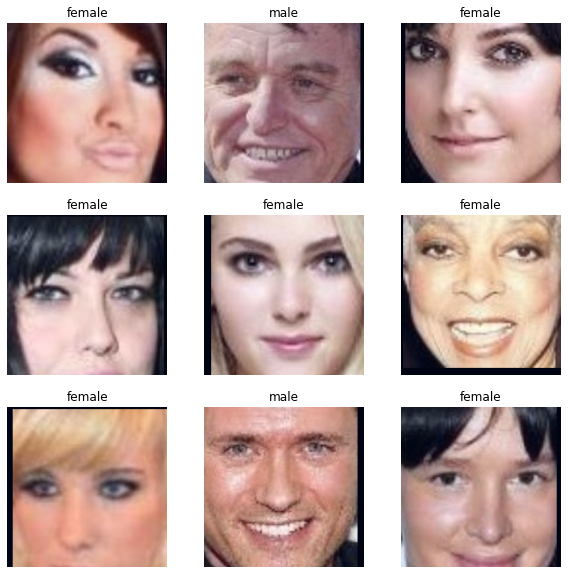

In [13]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

# Define the Network [Architecture](https://pytorch.org/docs/stable/nn.html)


We will use ResNet-50 pre-trained model

In [14]:
model = models.resnet50(pretrained=True)
# print(model)

Our dataset only has 2 classes, so we first create a new linear layer with the required dimensions.

In [15]:
IN_FEATURES = model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

model.fc = fc

In [16]:
# print(model)

We can also see the number of parameters in our model

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


## Specify Loss Function and Optimizer¶

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000], gamma=0.1)

## Training the Model

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
# number of epochs to train the model
n_epochs = 25

valid_loss_min = np.Inf # track change in validation loss
train_loss_list = []
valid_loss_list = []

print('Training started')
for epoch in range(1, n_epochs+1):
    start_time = time.monotonic()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        scheduler.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    train_loss_list.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_loss_list.append(valid_loss)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # print training/validation statistics 
    for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_gender.pt')
        valid_loss_min = valid_loss

Training started
Epoch: 02 | Epoch Time: 5m 43s
Current learning rate is: 0.001
Epoch: 1 	Training Loss: 0.144279 	Validation Loss: 0.126177
Validation loss decreased (inf --> 0.126177).  Saving model ...
Epoch: 03 | Epoch Time: 5m 43s
Current learning rate is: 0.001
Epoch: 2 	Training Loss: 0.128150 	Validation Loss: 0.115518
Validation loss decreased (0.126177 --> 0.115518).  Saving model ...
Epoch: 04 | Epoch Time: 5m 44s
Current learning rate is: 0.001
Epoch: 3 	Training Loss: 0.121394 	Validation Loss: 0.109687
Validation loss decreased (0.115518 --> 0.109687).  Saving model ...
Epoch: 05 | Epoch Time: 5m 42s
Current learning rate is: 0.0001
Epoch: 4 	Training Loss: 0.098679 	Validation Loss: 0.085022
Validation loss decreased (0.109687 --> 0.085022).  Saving model ...
Epoch: 06 | Epoch Time: 5m 46s
Current learning rate is: 0.0001
Epoch: 5 	Training Loss: 0.083428 	Validation Loss: 0.082555
Validation loss decreased (0.085022 --> 0.082555).  Saving model ...
Epoch: 07 | Epoch Tim

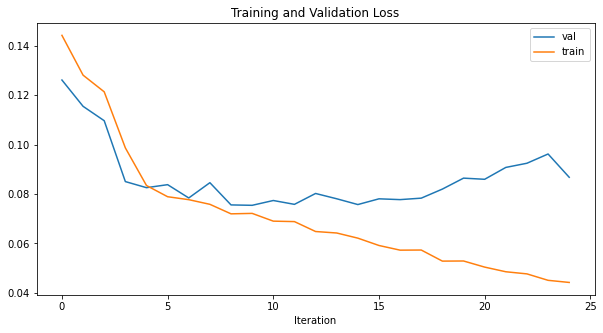

In [22]:
plt.figure(figsize=(10,5))
plt.title('Training and Validation Loss')
plt.plot(valid_loss_list, label='val')
plt.plot(train_loss_list, label='train')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [23]:
model.load_state_dict(torch.load('model_gender.pt'))

<All keys matched successfully>

In [29]:
# # track test loss
# test_loss = 0.0
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))

# model.eval()
# # iterate over test data
# for batch_idx, (data, target) in enumerate(test_loader):
#     # move tensors to GPU if CUDA is available
#     data, target = data.cuda(), target.cuda()
#     # forward pass: compute predicted outputs by passing inputs to the model
#     output = model(data)
#     # calculate the batch loss
#     loss = criterion(output, target)
#     # update test loss 
#     test_loss += loss.item()*data.size(0)
#     # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     # compare predictions to true label
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.cpu().numpy())
#     # calculate test accuracy for each object class
#     batch_size = data.size(0)
#     for i in range(batch_size):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1

# # average test loss
# test_loss = test_loss/len(test_loader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))

In [28]:
from sklearn.metrics import confusion_matrix


# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[5758   83]
 [ 201 5607]]
[98.57901044 96.5392562 ]


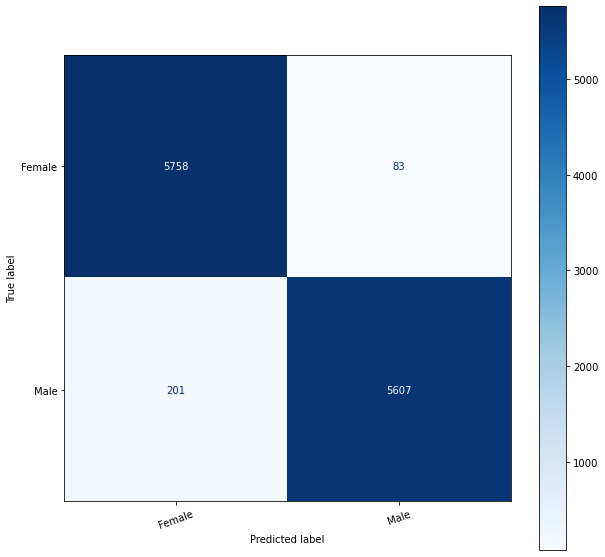

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
plot_confusion_matrix(lbllist.numpy(), predlist.numpy(), ['Female', 'Male'])

In [30]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
        
    model.train()

In [31]:
check_accuracy(test_loader, model)

Got 11365 / 11649 with accuracy 97.56


In [43]:
## Testing on real images
from PIL import Image

def test_on_image(path):
    with torch.no_grad():
        image = Image.open(path)
        plt.imshow(image)
        image = test_transforms(image)
        image.unsqueeze_(0)
        image = image.to(device)
        model.load_state_dict(torch.load('model_gender.pt'))
        model.eval()
        output = model(image)
        output = torch.max(output, 1)[1].to(device)
        print('Image predicted as ', output.item())

# model.eval()
# img = Image.open("C:/Users/Shahrullohon/Desktop/all/aa/9.jpg")
# x = test_transforms(img)
# x = x.unsqueeze(0)
# x = x.to(device)
# output = model(x)
# pred = torch.argmax(output, 1).to(device)
# print('Image predicted as ', pred)

Image predicted as  1


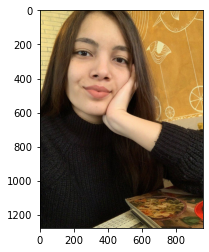

In [47]:
test_on_image("C:/Users/Shahrullohon/Desktop/all/aa/8.jpg")

In [59]:
def get_predictions(model, iterator):
    
    model.eval()
    
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x, y = x.cuda(), y.cuda()
            
            y_pred = model(x)
            
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)
            
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    return images, labels, probs

In [60]:
images, labels, probs = get_predictions(model, test_loader)

In [63]:
pred_labels = torch.argmax(probs, 1)

In [64]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

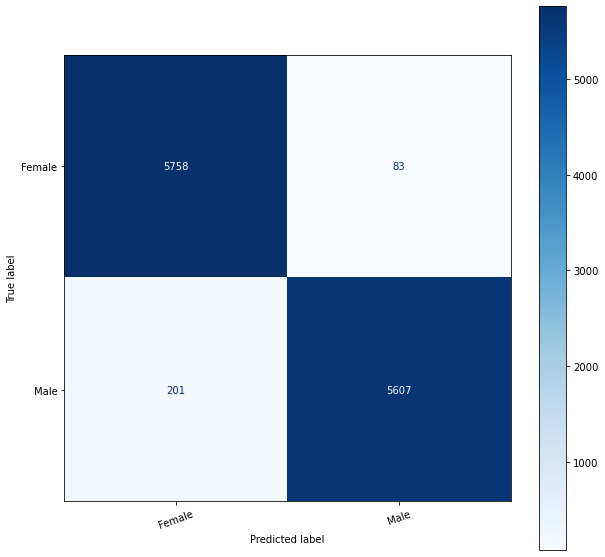

In [66]:
classes = ['Female', 'Male']

plot_confusion_matrix(labels, pred_labels, classes)

In [68]:
corrects = torch.eq(labels, pred_labels)

In [69]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))
        
incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [70]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

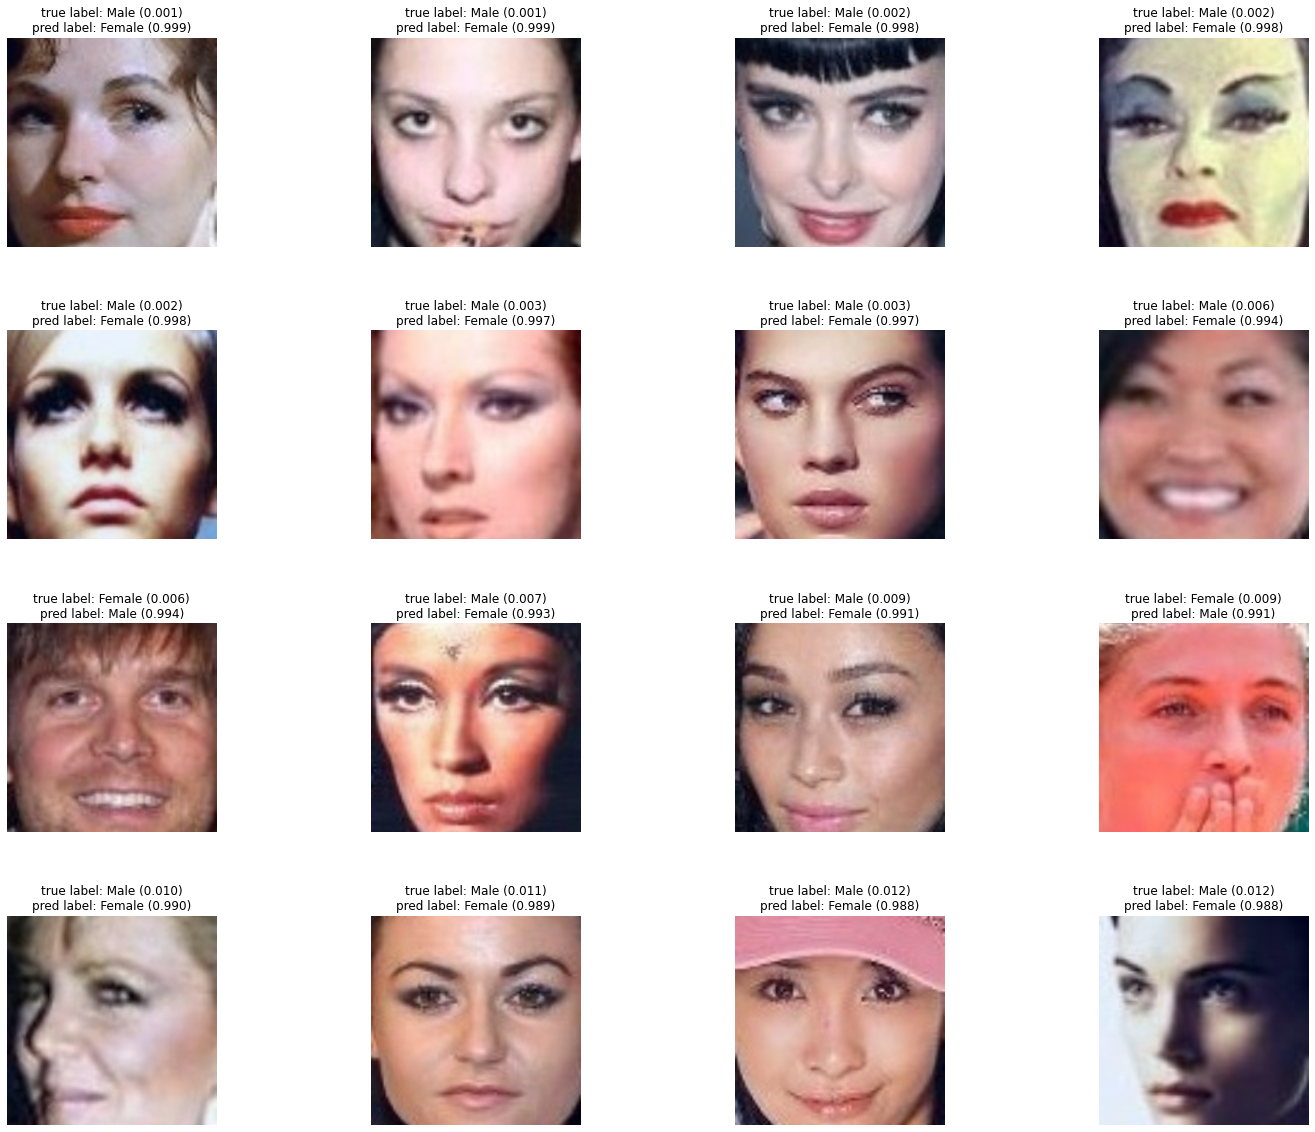

In [73]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)